In [1]:
#Import deps 
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTENC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Dataset

In [2]:
path = os.getcwd()
data = 'Resources\\Wine_data_both.csv'
path = path.replace('main',data)

df = pd.read_csv(path)

### <font color='blue'>Exploratory analysis<font>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  Wine                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [4]:
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
Wine                    0
dtype: int64

In [5]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Wine
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,White
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,White
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,White
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,White
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,White


#### Casting as category type

In [6]:
df['quality'] = df['quality'].astype('category')
df['Wine'] = df['Wine'].astype('category')

In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000


#### Feature distribution  Viz

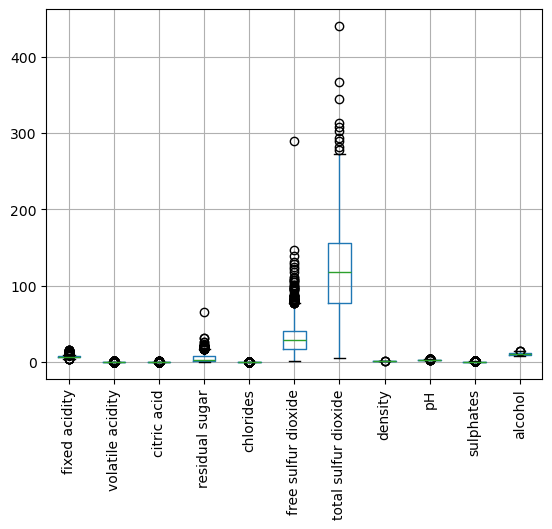

In [8]:
df.boxplot()
plt.xticks(rotation=90)
plt.show()

**Note:**
        The scale for 'total sulfur dioxide' and 'free sulfur dioxided' measurments are significantly bigger than the rest<br>
        of the features
    

#### Correlation

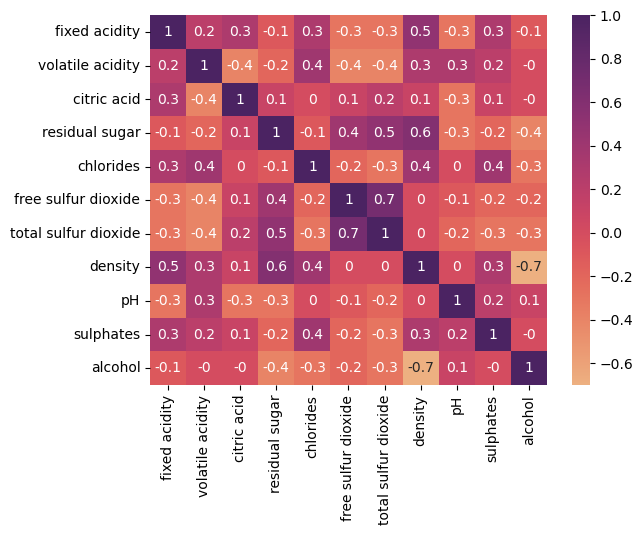

In [9]:
X_df = df.drop(columns = ['Wine','quality'])

X_corr = X_df.corr().round(1)

sns.heatmap(X_corr,annot=True,cmap='flare') 
plt.show()

**Note:**
            free sulfur dioxide and total sulfur dioxide have a significant positive correlation<br>
            alcohol and density have a significant negative correlation.

#### Target : Wine type

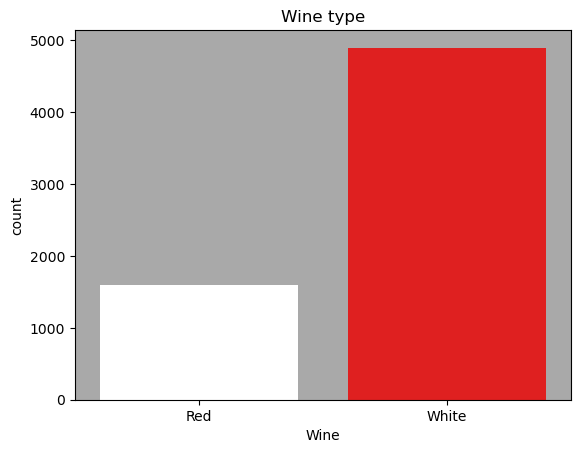

In [10]:
sns.set_style(rc = {'axes.facecolor': 'darkgrey'})
sns.countplot(
               x = df['Wine'],
               hue = df['Wine'],
               palette=['white',"red"]).set(title='Wine type'
              )
plt.show()

In [11]:
df['Wine'].value_counts()

Wine
White    4898
Red      1599
Name: count, dtype: int64

**Note:** 
    The target variable is heavily inbalanced 3 'White' to 1 'Red'

#### Target: Quality

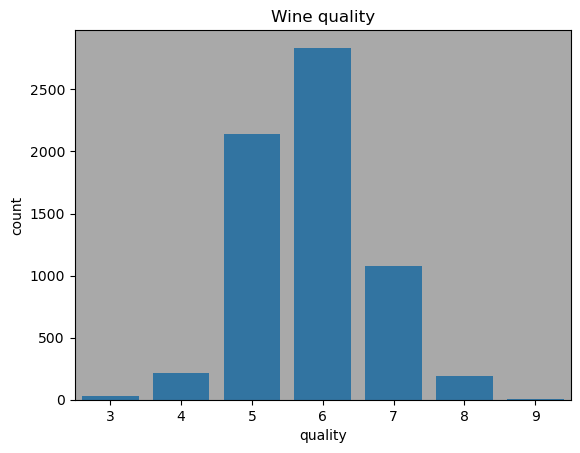

In [12]:
sns.countplot(x = df['quality']).set(title='Wine quality')
plt.show()

In [13]:
df['quality'].value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

#### Quality count by wine type

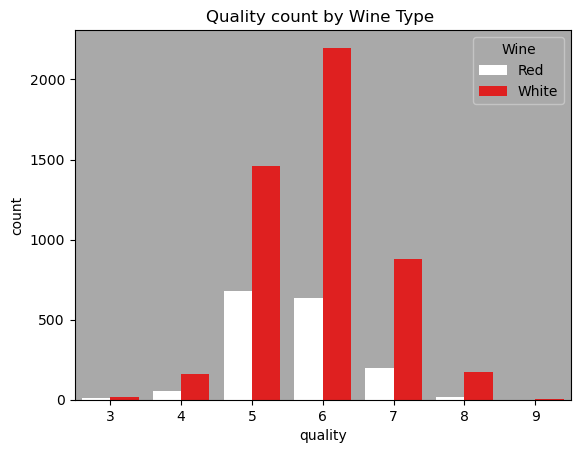

In [14]:
sns.set_style(rc = {'axes.facecolor': 'darkgrey'})
sns.countplot( x = df['quality'],
               hue = df['Wine'], 
               palette=['white',"red"]).set(title='Quality count by Wine Type ')
plt.show()

### Reclassifying target

In [15]:
df['quality'] = df['quality'].replace([3,4,5],'low')
df['quality'] = df['quality'].replace([6],'medium')
df['quality'] = df['quality'].replace([7,8,9],'high')


df['quality'] = df['quality'].astype('category')

### Reclassified Viz

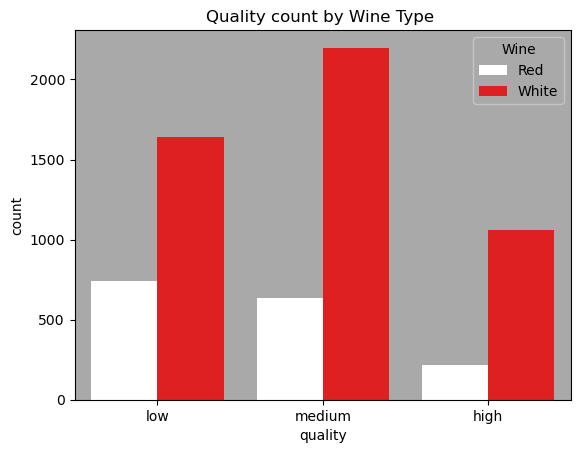

In [16]:
sns.set_style(rc = {'axes.facecolor': 'darkgrey'})
sns.countplot(
               x = df['quality'],
               hue = df['Wine'], 
               palette=['white',"red"]).set(title='Quality count by Wine Type ')
plt.show()

---

### Splitting and encoding features

In [17]:
X = df.drop(columns = ['Wine','quality',])
y = df['quality']

le = LabelEncoder()
le.fit(y)

y = le.transform(y)

---

### Over Sampling

In [18]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#### Viz

C:\Users\Chris\AppData\Local\Temp\ipykernel_3944\450106768.py:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  sns.countplot(x=y_resampled).set_xticklabels(le.classes_)


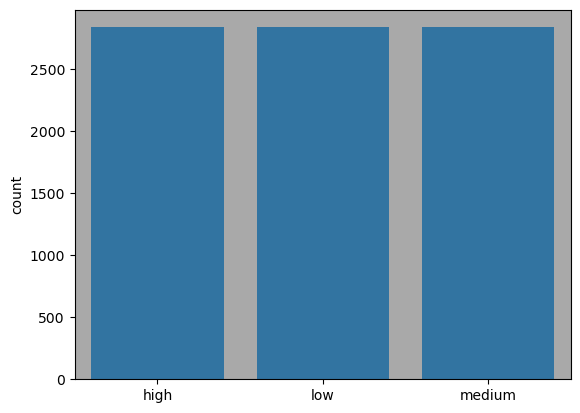

In [19]:
sns.countplot(x=y_resampled).set_xticklabels(le.classes_)
plt.show()

---

### Building Models

#### Splitting data

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,random_state=42)

---

#### KNeighborsClassifier

In [21]:
train_scores = []
test_scores = []
for n in range(1,10):
    knc = KNeighborsClassifier(n_neighbors = n)
    knc.fit(X_train,y_train)
    train_scores.append(knc.score(X_train,y_train))
    test_scores.append(knc.score(X_test,y_test))

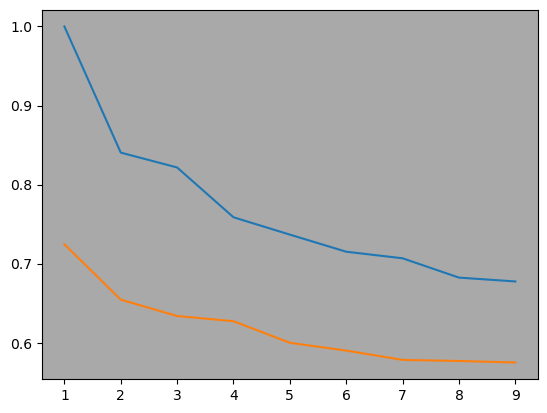

In [22]:
plt.plot([*range(1,10)],train_scores)
plt.plot([*range(1,10)],test_scores)
plt.show()

#### Model fit

In [23]:
knc = KNeighborsClassifier(n_neighbors = 1 )
knc.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=1)

#### Confusion Matrix

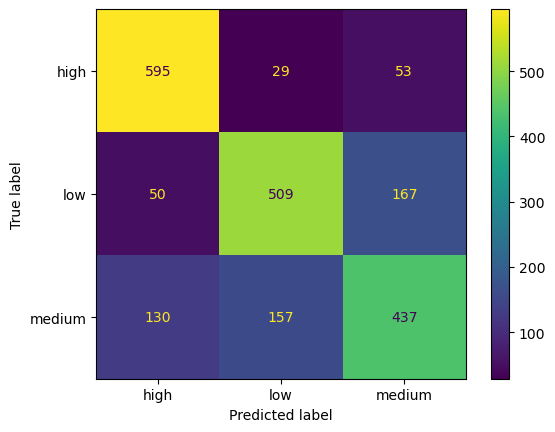

In [24]:
y_pred = knc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

In [25]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82       677
           1       0.73      0.70      0.72       726
           2       0.67      0.60      0.63       724

    accuracy                           0.72      2127
   macro avg       0.72      0.73      0.72      2127
weighted avg       0.72      0.72      0.72      2127



---

#### SVC

In [26]:
param_grid_svc = {
              'C': [5,10,15], 
              'gamma': [1,2,3,4],
              'kernel': ['rbf']
              }
grid_svc= GridSearchCV(
                       SVC(),
                       param_grid_svc,
                       refit=True,verbose=3
                       )

grid_svc.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.677 total time=   3.0s
[CV 2/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.706 total time=   3.0s
[CV 3/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.713 total time=   3.0s
[CV 4/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.686 total time=   2.8s
[CV 5/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.679 total time=   2.9s
[CV 1/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.647 total time=   2.7s
[CV 2/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.679 total time=   2.6s
[CV 3/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.687 total time=   2.8s
[CV 4/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.654 total time=   2.9s
[CV 5/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.662 total time=   2.8s
[CV 1/5] END ..........C=5, gamma=3, kernel=rbf;, score=0.630 total time=   2.9s
[CV 2/5] END ..........C=5, gamma=3, kernel=rbf;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [5, 10, 15], 'gamma': [1, 2, 3, 4],
                         'kernel': ['rbf']},
             verbose=3)

In [27]:
print(grid_svc.best_params_)
print(grid_svc.best_score_)

{'C': 5, 'gamma': 1, 'kernel': 'rbf'}
0.6920569614815287


#### Model fit

In [28]:
C = grid_svc.best_params_['C'] 
gamma = grid_svc.best_params_['gamma']
kernel = grid_svc.best_params_['kernel']
                              
svc = SVC(C = C,
         gamma = gamma,
         kernel = kernel)

svc.fit(X_train,y_train)

SVC(C=5, gamma=1)

#### Confusion Matrix

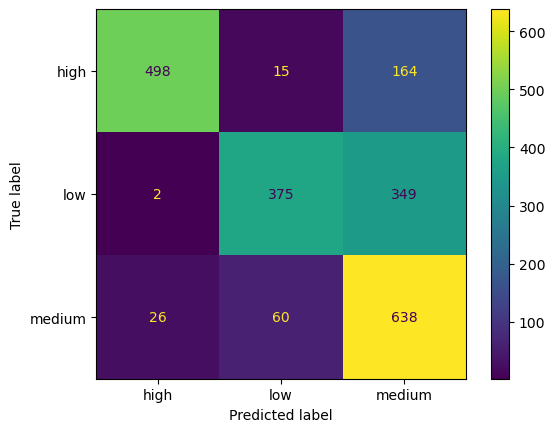

In [29]:
y_pred = svc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classfication Report

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.74      0.83       677
           1       0.83      0.52      0.64       726
           2       0.55      0.88      0.68       724

    accuracy                           0.71      2127
   macro avg       0.78      0.71      0.72      2127
weighted avg       0.77      0.71      0.71      2127



---

#### DecisionTreeClassifier

In [31]:
param_grid_dtc = { 
                  'criterion': ['gini', 'entropy', 'log_loss'], 
                  'splitter': ['best','random'],
                  'max_features': ['sqrt', 'log2'],
                  'max_depth': [10,20, 30], 
                  'max_leaf_nodes': [900,1000,1100],
                  'min_samples_split': [4,6,8], 
                    } 

grid_dtc = GridSearchCV(
                        DecisionTreeClassifier(),
                        param_grid_dtc,
                        refit=True,verbose=3
                       )

grid_dtc.fit(X_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.625 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.669 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.622 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.617 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.646 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.566 total time=   0.0s
[CV 2/5] END criterion=gini, max_d

[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.614 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.504 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.592 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.567 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.516 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.492 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, m

[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.639 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.620 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.618 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.607 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.561 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.558 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_sam

[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.674 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.657 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.627 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.648 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.619 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.635 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_sam

[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.656 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.638 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.636 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.614 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.649 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.622 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_

[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.679 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.670 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.643 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.636 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.597 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.632 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_sam

[CV 2/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.668 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.654 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.668 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.664 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.599 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.617 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_sam

[CV 3/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.632 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.650 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.644 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.613 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.639 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.615 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_

[CV 4/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.639 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.643 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.616 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.649 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.620 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.619 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1100, min

[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.637 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.632 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.579 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.543 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.596 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.556 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, max

[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.611 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.637 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.607 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.627 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.637 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.567 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=

[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.600 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.568 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.498 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.526 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.646 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.676 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_l

[CV 4/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.650 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.651 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.646 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.654 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.603 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.616 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=sqrt, max

[CV 1/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.660 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.663 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.662 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.658 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.661 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.634 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_

[CV 5/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.641 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.626 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.639 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.603 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.604 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.616 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_lea

[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.623 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.634 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.613 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.641 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.656 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.647 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_l

[CV 2/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.687 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.651 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.633 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.649 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.610 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.650 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=log2, max_lea

[CV 5/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.617 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.581 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.576 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.563 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.551 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.555 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=sqrt, 

[CV 1/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.628 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.620 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.646 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.611 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.636 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.525 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=sqrt, ma

[CV 5/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.603 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.572 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.562 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.545 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.531 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.545 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=

[CV 3/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.653 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.637 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.644 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.577 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.609 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.615 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_

[CV 1/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.644 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.668 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.673 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.672 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.661 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.620 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf

[CV 4/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.668 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.642 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.613 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.636 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.652 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.628 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=lo

[CV 2/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.672 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.661 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.649 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.653 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.614 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.646 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=sqrt, 

[CV 5/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.632 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.614 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.613 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.612 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.622 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.624 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=log2, 

[CV 2/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.646 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.638 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.652 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.628 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.611 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.624 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=log2, 

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [900, 1000, 1100],
                         'min_samples_split': [4, 6, 8],
                         'splitter': ['best', 'random']},
             verbose=3)

In [32]:
print(grid_dtc.best_params_)
print(grid_dtc.best_score_)

{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 1100, 'min_samples_split': 4, 'splitter': 'best'}
0.6696456231911097


#### Model Fit

In [33]:
dtc = DecisionTreeClassifier( 
                             criterion =grid_dtc.best_params_['criterion'],
                             splitter = grid_dtc.best_params_['splitter'],
                             max_features =  grid_dtc.best_params_['max_features'],
                             max_depth =  grid_dtc.best_params_['max_depth'], 
                             max_leaf_nodes = grid_dtc.best_params_['max_leaf_nodes'],
                             min_samples_split = grid_dtc.best_params_['min_samples_split']
    
                            )

dtc.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=1100, min_samples_split=4)

#### Confusion Matrix

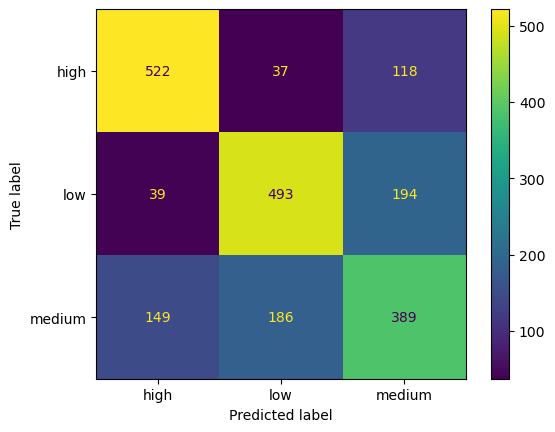

In [34]:
y_pred = dtc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classfication Report

In [35]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       677
           1       0.69      0.68      0.68       726
           2       0.55      0.54      0.55       724

    accuracy                           0.66      2127
   macro avg       0.66      0.66      0.66      2127
weighted avg       0.66      0.66      0.66      2127



---

#### RandomForestClassifier

In [36]:
param_grid_rfc = { 
                 'n_estimators': [200, 215,220], 
                 'max_features': ['sqrt', 'log2', None], 
                 'max_depth': [10,20, 30], 
                 'max_leaf_nodes': [900,1000,1100],
                 'min_samples_split': [4,6,8], 
                 } 

grid_rfc = GridSearchCV(
                        RandomForestClassifier(),
                        param_grid_rfc,
                        refit=True,verbose=3
                       )

grid_rfc.fit(X_train,y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.692 total time=   1.7s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.726 total time=   1.6s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.719 total time=   1.6s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.700 total time=   1.6s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.716 total time=   1.6s
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.694 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.

[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.689 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.737 total time=   1.8s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.707 total time=   1.7s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.704 total time=   1.7s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.704 total time=   1.7s
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.690 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.725 total time=   1.8s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.684 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.723 total time=   1.8s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.712 total time=   1.9s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.696 total time=   1.6s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.709 total time=   1.8s
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.692 total time=   2.1s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.723 total time=   1.9s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.699 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.729 total time=   1.8s
[CV 3/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.713 total time=   1.7s
[CV 4/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.703 total time=   1.9s
[CV 5/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.711 total time=   2.0s
[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.690 total time=   2.1s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.730 total time=   1.9s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.689 total time=   2.0s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.724 total time=   1.9s
[CV 3/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.714 total time=   1.9s
[CV 4/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.706 total time=   1.8s
[CV 5/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.710 total time=   1.9s
[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.683 total time=   2.1s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.736 total time=   1.9s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.695 total time=   5.2s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.723 total time=   5.4s
[CV 3/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.701 total time=   5.1s
[CV 4/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.691 total time=   5.2s
[CV 5/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.694 total time=   5.3s
[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.693 total time=   5.6s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.728 total time=   5.6s
[CV 3/5] END max_depth=10, max_features=N

[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.702 total time=   5.2s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.730 total time=   5.2s
[CV 3/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.711 total time=   5.2s
[CV 4/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.704 total time=   5.2s
[CV 5/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.705 total time=   5.2s
[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.701 total time=   5.6s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.731 total time=   5.6s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.746 total time=   2.2s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.759 total time=   2.2s
[CV 3/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.749 total time=   2.3s
[CV 4/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.739 total time=   2.2s
[CV 5/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.742 total time=   2.2s
[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.749 total time=   2.4s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.764 total time=   2.4s
[CV 3/5] END max_depth=20, max_features=s

[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.735 total time=   2.2s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.768 total time=   2.2s
[CV 3/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.742 total time=   2.2s
[CV 4/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.745 total time=   2.2s
[CV 5/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.741 total time=   2.2s
[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.733 total time=   2.3s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.767 total time=   2.4s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.745 total time=   2.3s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.770 total time=   2.3s
[CV 3/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.752 total time=   2.3s
[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.737 total time=   2.3s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.749 total time=   2.3s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.757 total time=   2.5s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.772 total time=   2.5s
[CV 3/5] END max_depth=20, max_features=l

[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.747 total time=   2.3s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.759 total time=   2.2s
[CV 3/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.741 total time=   2.2s
[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.743 total time=   2.2s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.737 total time=   2.2s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.756 total time=   2.5s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.763 total time=   2.4s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.732 total time=   2.2s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.755 total time=   2.2s
[CV 3/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.751 total time=   2.2s
[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.742 total time=   2.2s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.735 total time=   2.2s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.727 total time=   2.3s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.766 total time=   2.4s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.743 total time=   7.1s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.768 total time=   7.3s
[CV 3/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.733 total time=   7.4s
[CV 4/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.748 total time=   7.1s
[CV 5/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.737 total time=   7.1s
[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.738 total time=   7.6s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.765 total time=   7.6s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.735 total time=   7.1s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.762 total time=   7.0s
[CV 3/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.734 total time=   7.0s
[CV 4/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.735 total time=   7.0s
[CV 5/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.730 total time=   7.0s
[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.738 total time=   7.6s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.760 total time=   7.6s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.745 total time=   2.2s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.759 total time=   2.2s
[CV 3/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.745 total time=   2.2s
[CV 4/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.745 total time=   2.2s
[CV 5/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.735 total time=   2.2s
[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.735 total time=   3.2s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.758 total time=   4.2s
[CV 3/5] END max_depth=30, max_features=s

[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.757 total time=   2.3s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.759 total time=   2.3s
[CV 3/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.754 total time=   2.3s
[CV 4/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.755 total time=   2.3s
[CV 5/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.742 total time=   2.3s
[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.744 total time=   2.5s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.763 total time=   2.5s
[CV 3/5] END max_depth=30, max_fea

[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.748 total time=   2.3s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.760 total time=   2.3s
[CV 3/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.737 total time=   2.2s
[CV 4/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.744 total time=   2.3s
[CV 5/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.734 total time=   2.3s
[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.742 total time=   2.5s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.768 total time=   2.4s
[CV 3/5] END max_depth=30, max_features=l

[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.745 total time=   2.2s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.769 total time=   2.3s
[CV 3/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.736 total time=   2.2s
[CV 4/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.734 total time=   2.2s
[CV 5/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.737 total time=   2.2s
[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.741 total time=   2.4s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.755 total time=   2.4s
[CV 3/5] END max_depth=30, max_fea

[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.737 total time=   7.1s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.772 total time=   7.2s
[CV 3/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.743 total time=   7.2s
[CV 4/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.739 total time=   7.2s
[CV 5/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.735 total time=   7.2s
[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.747 total time=   7.7s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.770 total time=   8.2s
[CV 3/5] END max_depth=30, max_features=N

[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.742 total time=   7.1s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.761 total time=   7.1s
[CV 3/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.732 total time=   7.1s
[CV 4/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.737 total time=   7.2s
[CV 5/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.726 total time=   7.1s
[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.735 total time=   7.6s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.758 total time=   7.6s
[CV 3/5] END max_depth=30, max_fea

[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.728 total time=   7.0s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.760 total time=   7.1s
[CV 3/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.740 total time=   6.9s
[CV 4/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.732 total time=   7.0s
[CV 5/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.725 total time=   6.9s
[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.738 total time=   7.5s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.763 total time=   7.5s
[CV 3/5] END max_depth=30, max_fea

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [900, 1000, 1100],
                         'min_samples_split': [4, 6, 8],
                         'n_estimators': [200, 215, 220]},
             verbose=3)

In [37]:
print(grid_rfc.best_params_)
print(grid_rfc.best_score_)

{'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 1100, 'min_samples_split': 4, 'n_estimators': 200}
0.753486325464021


#### Model fit

In [38]:
rfc = RandomForestClassifier( 
                             n_estimators = grid_rfc.best_params_['n_estimators'], 
                             max_features =  grid_rfc.best_params_['max_features'],
                             max_depth =  grid_rfc.best_params_['max_depth'], 
                             max_leaf_nodes = grid_rfc.best_params_['max_leaf_nodes'],
                        
                            )

rfc.fit(X_train,y_train)

RandomForestClassifier(max_depth=30, max_leaf_nodes=1100, n_estimators=200)

#### Confusion Matrix

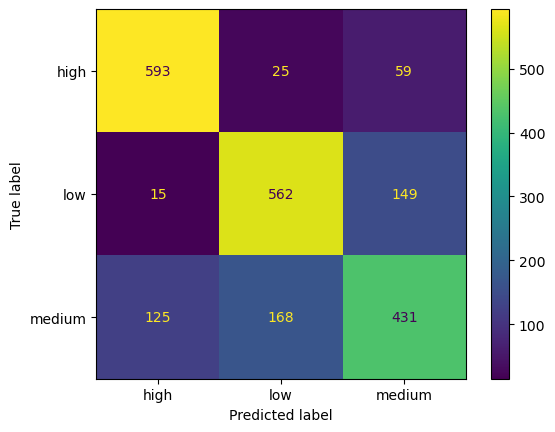

In [39]:
y_pred = rfc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classfication Report

In [40]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       677
           1       0.74      0.77      0.76       726
           2       0.67      0.60      0.63       724

    accuracy                           0.75      2127
   macro avg       0.74      0.75      0.74      2127
weighted avg       0.74      0.75      0.74      2127



---

#### AdaBoostClassifier (estimator = DecisionTreeClassifier)

In [41]:
param_grid_abc_dt = { 
                     'n_estimators': [210,212,215,],
                     'learning_rate':[0.5,0.75,1]
                    }

dtc = DecisionTreeClassifier( 
                             criterion =grid_dtc.best_params_['criterion'],
                             splitter = grid_dtc.best_params_['splitter'],
                             max_features =  grid_dtc.best_params_['max_features'],
                             max_depth =  grid_dtc.best_params_['max_depth'], 
                             max_leaf_nodes = grid_dtc.best_params_['max_leaf_nodes'],
                             min_samples_split = grid_dtc.best_params_['min_samples_split']
    
                            )


abc_dt = AdaBoostClassifier(estimator = dtc)

grid_abc_dt= GridSearchCV(
                          abc_dt,
                          param_grid_abc_dt,
                          refit=True,verbose=3
                          )

grid_abc_dt.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.5, n_estimators=210;, score=0.764 total time=   5.4s
[CV 2/5] END learning_rate=0.5, n_estimators=210;, score=0.776 total time=   5.4s
[CV 3/5] END learning_rate=0.5, n_estimators=210;, score=0.769 total time=   5.3s
[CV 4/5] END learning_rate=0.5, n_estimators=210;, score=0.753 total time=   5.4s
[CV 5/5] END learning_rate=0.5, n_estimators=210;, score=0.750 total time=   5.3s
[CV 1/5] END learning_rate=0.5, n_estimators=212;, score=0.758 total time=   5.4s
[CV 2/5] END learning_rate=0.5, n_estimators=212;, score=0.789 total time=   5.4s
[CV 3/5] END learning_rate=0.5, n_estimators=212;, score=0.758 total time=   5.3s
[CV 4/5] END learning_rate=0.5, n_estimators=212;, score=0.745 total time=   5.3s
[CV 5/5] END learning_rate=0.5, n_estimators=212;, score=0.755 total time=   5.4s
[CV 1/5] END learning_rate=0.5, n_estimators=215;, score=0.759 total time=   5.5s
[CV 2/5] END learning_rate=0.5, n_esti

GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                           max_depth=30,
                                                                           max_features='sqrt',
                                                                           max_leaf_nodes=1100,
                                                                           min_samples_split=4)),
             param_grid={'learning_rate': [0.5, 0.75, 1],
                         'n_estimators': [210, 212, 215]},
             verbose=3)

In [42]:
print(grid_abc_dt.best_params_)
print(grid_abc_dt.best_score_)

{'learning_rate': 0.75, 'n_estimators': 212}
0.7638310303095764


#### Model fit

In [43]:
dtc = DecisionTreeClassifier( 
                             criterion =grid_dtc.best_params_['criterion'],
                             splitter = grid_dtc.best_params_['splitter'],
                             max_features =  grid_dtc.best_params_['max_features'],
                             max_depth =  grid_dtc.best_params_['max_depth'], 
                             max_leaf_nodes = grid_dtc.best_params_['max_leaf_nodes'],
                             min_samples_split = grid_dtc.best_params_['min_samples_split']
    
                            )

abc_dt = AdaBoostClassifier(
                        estimator = dtc,
                        n_estimators = grid_abc_dt.best_params_['n_estimators'],
                        learning_rate= grid_abc_dt.best_params_['learning_rate']
                        )

abc_dt.fit(X_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=30,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=1100,
                                                    min_samples_split=4),
                   learning_rate=0.75, n_estimators=212)

#### Confusion Matrix

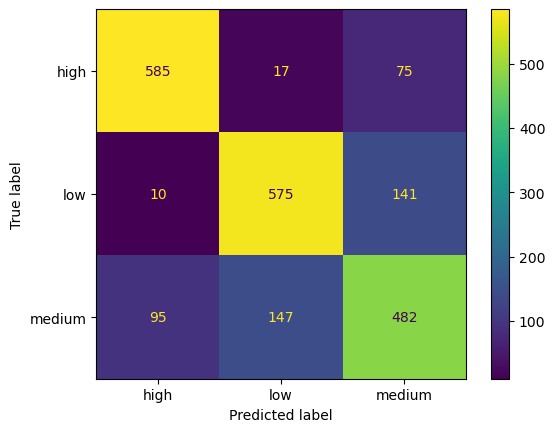

In [44]:
y_pred = abc_dt.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classification Report

In [45]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       677
           1       0.78      0.79      0.78       726
           2       0.69      0.67      0.68       724

    accuracy                           0.77      2127
   macro avg       0.77      0.77      0.77      2127
weighted avg       0.77      0.77      0.77      2127



---

#### AdaBoostClassifier (estimator = RandomForestClassifier)

In [46]:
param_grid_abc_rfc = { 
                      'n_estimators': [210,212,215,],
                      'learning_rate':[0.5,0.75,1]
                     }

rfc = RandomForestClassifier( 
                             n_estimators = grid_rfc.best_params_['n_estimators'], 
                             max_features =  grid_rfc.best_params_['max_features'],
                             max_depth =  grid_rfc.best_params_['max_depth'], 
                             max_leaf_nodes = grid_rfc.best_params_['max_leaf_nodes'],
                             
                            )

abc_rfc = AdaBoostClassifier(estimator = rfc)

grid_abc_rfc = GridSearchCV(
                           abc_rfc,
                           param_grid_abc_rfc,
                           refit=True,verbose=3
                           )

grid_abc_rfc.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.5, n_estimators=210;, score=0.756 total time=   2.6s
[CV 2/5] END learning_rate=0.5, n_estimators=210;, score=0.766 total time=   2.6s
[CV 3/5] END learning_rate=0.5, n_estimators=210;, score=0.752 total time=   2.5s
[CV 4/5] END learning_rate=0.5, n_estimators=210;, score=0.743 total time=   2.5s
[CV 5/5] END learning_rate=0.5, n_estimators=210;, score=0.744 total time=   2.5s
[CV 1/5] END learning_rate=0.5, n_estimators=212;, score=0.751 total time=   2.5s
[CV 2/5] END learning_rate=0.5, n_estimators=212;, score=0.761 total time=   2.6s
[CV 3/5] END learning_rate=0.5, n_estimators=212;, score=0.751 total time=   2.5s
[CV 4/5] END learning_rate=0.5, n_estimators=212;, score=0.739 total time=   2.5s
[CV 5/5] END learning_rate=0.5, n_estimators=212;, score=0.738 total time=   2.5s
[CV 1/5] END learning_rate=0.5, n_estimators=215;, score=0.743 total time=   2.5s
[CV 2/5] END learning_rate=0.5, n_esti

GridSearchCV(estimator=AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=30,
                                                                           max_leaf_nodes=1100,
                                                                           n_estimators=200)),
             param_grid={'learning_rate': [0.5, 0.75, 1],
                         'n_estimators': [210, 212, 215]},
             verbose=3)

In [47]:
print(grid_abc_rfc.best_params_)
print(grid_abc_rfc.best_score_)

{'learning_rate': 1, 'n_estimators': 212}
0.7531735822841054


#### Model Fit

In [48]:
rfc = RandomForestClassifier( 
                             n_estimators = grid_rfc.best_params_['n_estimators'], 
                             max_features =  grid_rfc.best_params_['max_features'],
                             max_depth =  grid_rfc.best_params_['max_depth'], 
                             max_leaf_nodes = grid_rfc.best_params_['max_leaf_nodes'],
                             
    
                            )

abc_rfc = AdaBoostClassifier(
                             estimator = rfc,
                             n_estimators = grid_abc_rfc.best_params_['n_estimators'],
                             learning_rate= grid_abc_rfc.best_params_['learning_rate']
                            )

abc_rfc.fit(X_train,y_train)

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=30,
                                                    max_leaf_nodes=1100,
                                                    n_estimators=200),
                   learning_rate=1, n_estimators=212)

#### Confusion Matrix

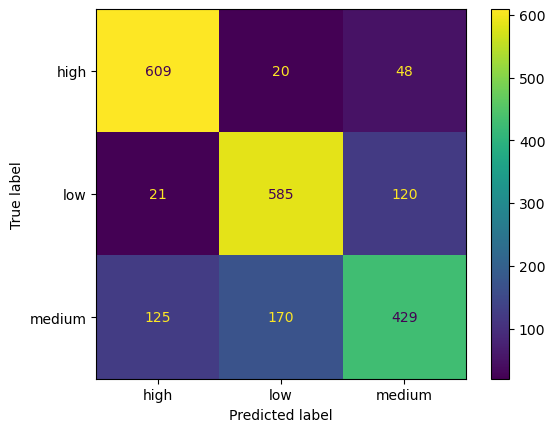

In [49]:
y_pred = abc_rfc.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classification Report

In [50]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       677
           1       0.75      0.81      0.78       726
           2       0.72      0.59      0.65       724

    accuracy                           0.76      2127
   macro avg       0.76      0.77      0.76      2127
weighted avg       0.76      0.76      0.76      2127



---

---

### Scaled

#### Scaling Data

In [51]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

#### Feature distribution  Viz

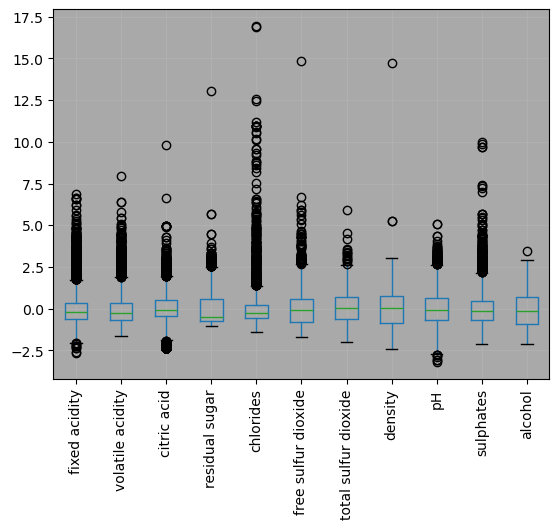

In [52]:
cols = df.drop(columns=['Wine','quality']).columns

X_df = pd.DataFrame(X_scaled,columns = cols)
X_df.boxplot()
plt.xticks(rotation=90)
plt.show()

### Scaling Data

In [53]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

---

#### KNeighborsClassifier

In [54]:
train_scores_scaled = []
test_scores_scaled = []
for n in range(1,10):
    knc_scaled = KNeighborsClassifier(n_neighbors = n)
    knc_scaled.fit(
            X_train_scaled,
            y_train
           )
    train_scores_scaled.append(knc_scaled.score(X_train_scaled,y_train))
    test_scores_scaled.append(knc_scaled.score(X_test_scaled,y_test))

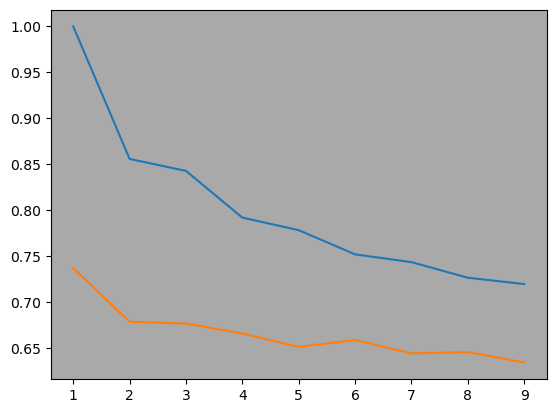

In [55]:
plt.plot([*range(1,10)],train_scores_scaled)
plt.plot([*range(1,10)],test_scores_scaled)
plt.show()

#### Model fit

In [56]:
knc_scaled = KNeighborsClassifier(n_neighbors = 1 )
knc_scaled.fit(X_train_scaled,y_train)

KNeighborsClassifier(n_neighbors=1)

#### Confusion Matrix

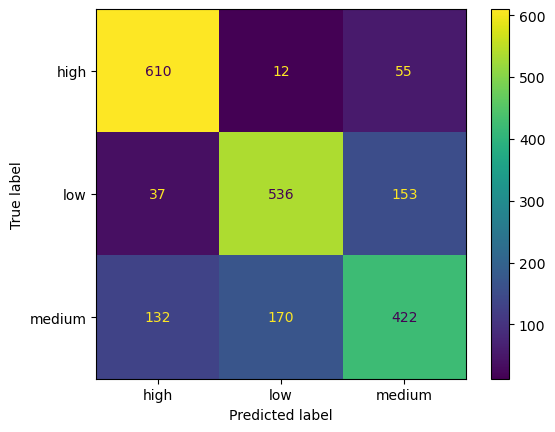

In [57]:
y_pred = knc_scaled.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classification Report

In [58]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       677
           1       0.75      0.74      0.74       726
           2       0.67      0.58      0.62       724

    accuracy                           0.74      2127
   macro avg       0.73      0.74      0.73      2127
weighted avg       0.73      0.74      0.73      2127



---

#### SVC

In [59]:
param_grid_svc_scaled = {
              'C': [5,10,15], 
              'gamma': [1,2,3,4],
              'kernel': ['rbf']
              }
grid_svc_scaled= GridSearchCV(
                              SVC(),
                              param_grid_svc_scaled,
                              refit=True,verbose=3
                             )

grid_svc_scaled.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.741 total time=   2.0s
[CV 2/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.764 total time=   1.8s
[CV 3/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.759 total time=   1.7s
[CV 4/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.727 total time=   1.7s
[CV 5/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.739 total time=   1.8s
[CV 1/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.730 total time=   1.8s
[CV 2/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.750 total time=   1.9s
[CV 3/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.743 total time=   1.8s
[CV 4/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.711 total time=   1.8s
[CV 5/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.722 total time=   1.8s
[CV 1/5] END ..........C=5, gamma=3, kernel=rbf;, score=0.718 total time=   1.7s
[CV 2/5] END ..........C=5, gamma=3, kernel=rbf;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [5, 10, 15], 'gamma': [1, 2, 3, 4],
                         'kernel': ['rbf']},
             verbose=3)

In [60]:
print(grid_svc_scaled.best_params_)
print(grid_svc_scaled.best_score_)

{'C': 5, 'gamma': 1, 'kernel': 'rbf'}
0.746122131857827


#### Model Fit

In [61]:
C = grid_svc_scaled.best_params_['C'] 
gamma = grid_svc_scaled.best_params_['gamma']
kernel = grid_svc_scaled.best_params_['kernel']
                              
svc_scaled = SVC(C = C,
         gamma = gamma,
         kernel = kernel)

svc_scaled.fit(X_train_scaled,y_train)

SVC(C=5, gamma=1)

#### Confusion Matrix

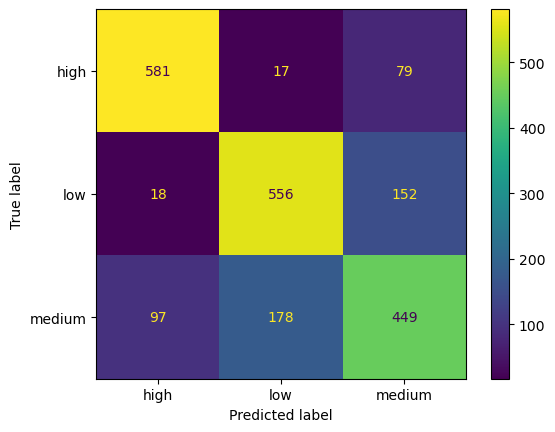

In [62]:
y_pred = svc_scaled.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classification Report

In [63]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85       677
           1       0.74      0.77      0.75       726
           2       0.66      0.62      0.64       724

    accuracy                           0.75      2127
   macro avg       0.75      0.75      0.75      2127
weighted avg       0.74      0.75      0.74      2127



---

#### DecisionTreeClassifier

In [64]:
param_grid_dtc_scaled = { 
                  'criterion': ['gini', 'entropy', 'log_loss'], 
                  'splitter': ['best','random'],
                  'max_features': ['sqrt', 'log2'],
                  'max_depth': [10,20, 30], 
                  'max_leaf_nodes': [900,1000,1100],
                  'min_samples_split': [4,6,8], 
                    } 

grid_dtc_scaled = GridSearchCV(
                        DecisionTreeClassifier(),
                        param_grid_dtc_scaled,
                        refit=True,verbose=3
                       )

grid_dtc_scaled.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.624 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.636 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.629 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.635 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.624 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.553 total time=   0.0s
[CV 2/5] END criterion=gini, max_d

[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.633 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.618 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.614 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.551 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.576 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.557 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_s

[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.620 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.647 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.654 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.594 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.638 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.456 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_sampl

[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.636 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.614 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.585 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.610 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.617 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.675 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min

[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.626 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.659 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.599 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.658 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.615 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.634 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=900, min_sample

[CV 3/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.647 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.665 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.669 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.625 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.629 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.633 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_

[CV 5/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.636 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.655 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.679 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.628 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.644 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.648 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_sampl

[CV 1/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.618 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.612 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.611 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.589 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.625 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.659 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, m

[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.519 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.521 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.601 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.665 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.632 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.609 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_node

[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.632 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.659 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.651 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.638 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.612 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.570 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=

[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.638 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.621 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.591 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.637 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.510 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.565 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=log2, max_lea

[CV 2/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.654 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.625 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.614 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.639 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.661 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.694 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, max

[CV 4/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.648 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.654 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.614 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.640 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.596 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.598 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_

[CV 3/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.613 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.636 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.634 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.652 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.678 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.642 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=log2, max_l

[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.667 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.655 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.639 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.634 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.661 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.626 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_l

[CV 3/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.637 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.625 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.634 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.655 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.674 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.650 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_no

[CV 2/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.652 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.667 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.660 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.652 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.613 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.636 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=log2, max_lea

[CV 1/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.612 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.611 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.621 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.615 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.639 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.536 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=sqrt, ma

[CV 2/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.556 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.615 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.556 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.538 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.621 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.651 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=log2, ma

[CV 1/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.618 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.635 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.618 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.594 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.628 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.550 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=log2, ma

[CV 1/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.630 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.672 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.658 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.647 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.650 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.621 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=sqrt, ma

[CV 4/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.657 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.618 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.608 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.654 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.615 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.614 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=log2, ma

[CV 4/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.577 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.601 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.649 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.688 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.667 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.635 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=log2, 

[CV 3/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.623 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.603 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.624 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.630 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.656 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.661 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=sqrt

[CV 3/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.664 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.639 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.653 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.624 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.644 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.624 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=log2, max_

[CV 4/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.614 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.607 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.624 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.670 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.639 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.625 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=log2, 

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [900, 1000, 1100],
                         'min_samples_split': [4, 6, 8],
                         'splitter': ['best', 'random']},
             verbose=3)

In [65]:
print(grid_dtc_scaled.best_params_)
print(grid_dtc_scaled.best_score_)

{'criterion': 'entropy', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 1100, 'min_samples_split': 4, 'splitter': 'best'}
0.6712103210158998


#### Model Fit

In [66]:
dtc_scaled = DecisionTreeClassifier( 
                             criterion =grid_dtc_scaled.best_params_['criterion'],
                             splitter = grid_dtc_scaled.best_params_['splitter'],
                             max_features =  grid_dtc_scaled.best_params_['max_features'],
                             max_depth =  grid_dtc_scaled.best_params_['max_depth'], 
                             max_leaf_nodes = grid_dtc_scaled.best_params_['max_leaf_nodes'],
                             min_samples_split = grid_dtc_scaled.best_params_['min_samples_split']
    
                            )

dtc_scaled.fit(X_train_scaled,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=30, max_features='sqrt',
                       max_leaf_nodes=1100, min_samples_split=4)

#### Confusion Matrix

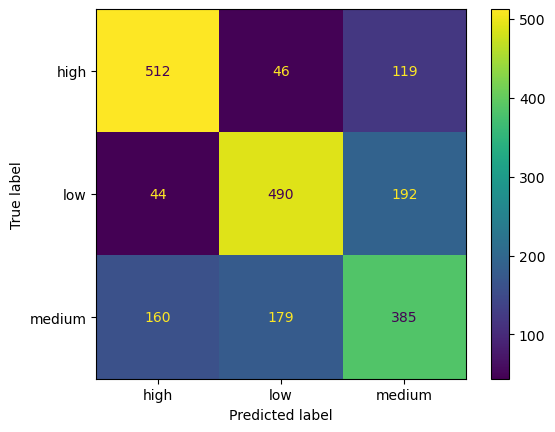

In [67]:
y_pred = dtc_scaled.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classfication Report

In [68]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.76      0.74       677
           1       0.69      0.67      0.68       726
           2       0.55      0.53      0.54       724

    accuracy                           0.65      2127
   macro avg       0.65      0.65      0.65      2127
weighted avg       0.65      0.65      0.65      2127



---

#### RandomForestClassifier

In [69]:
param_grid_rfc_scaled = { 
                 'n_estimators': [200, 215,220], 
                 'max_features': ['sqrt', 'log2', None], 
                 'max_depth': [10,20, 30], 
                 'max_leaf_nodes': [900,1000,1100],
                 'min_samples_split': [4,6,8], 
                 } 

grid_rfc_scaled = GridSearchCV(
                        RandomForestClassifier(),
                        param_grid_rfc_scaled,
                        refit=True,verbose=3
                       )

grid_rfc_scaled.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.692 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.729 total time=   1.8s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.712 total time=   1.7s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.704 total time=   1.9s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.703 total time=   1.9s
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.689 total time=   1.9s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.

[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.699 total time=   1.6s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.724 total time=   1.6s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.708 total time=   1.6s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.697 total time=   1.6s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.705 total time=   1.6s
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.692 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.726 total time=   1.8s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.687 total time=   1.6s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.721 total time=   1.6s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.709 total time=   1.8s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.698 total time=   1.6s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.712 total time=   1.6s
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.680 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.718 total time=   1.8s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.691 total time=   1.6s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.730 total time=   1.7s
[CV 3/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.719 total time=   1.7s
[CV 4/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.697 total time=   1.6s
[CV 5/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.706 total time=   1.6s
[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.695 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.737 total time=   1.8s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.697 total time=   1.7s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.724 total time=   1.6s
[CV 3/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.714 total time=   1.6s
[CV 4/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.702 total time=   1.6s
[CV 5/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.701 total time=   1.6s
[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.698 total time=   1.8s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.728 total time=   1.8s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.695 total time=   5.1s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.725 total time=   5.2s
[CV 3/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.708 total time=   5.1s
[CV 4/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.693 total time=   5.1s
[CV 5/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.705 total time=   5.1s
[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.691 total time=   5.5s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.724 total time=   5.8s
[CV 3/5] END max_depth=10, max_features=N

[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.705 total time=   5.2s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.734 total time=   5.2s
[CV 3/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.706 total time=   5.1s
[CV 4/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.694 total time=   5.1s
[CV 5/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.703 total time=   5.2s
[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.704 total time=   5.6s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.736 total time=   5.6s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.741 total time=   2.3s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.760 total time=   2.2s
[CV 3/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.751 total time=   2.2s
[CV 4/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.739 total time=   2.2s
[CV 5/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.737 total time=   2.2s
[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.743 total time=   2.4s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.753 total time=   2.4s
[CV 3/5] END max_depth=20, max_features=s

[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.737 total time=   2.2s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.762 total time=   2.2s
[CV 3/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.749 total time=   2.1s
[CV 4/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.726 total time=   2.2s
[CV 5/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.745 total time=   2.2s
[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.738 total time=   2.3s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.756 total time=   2.3s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.739 total time=   2.5s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.763 total time=   2.5s
[CV 3/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.753 total time=   2.4s
[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.745 total time=   2.3s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.745 total time=   2.3s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.748 total time=   2.4s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.766 total time=   2.5s
[CV 3/5] END max_depth=20, max_features=l

[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.746 total time=   2.2s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.761 total time=   2.2s
[CV 3/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.742 total time=   2.2s
[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.731 total time=   2.2s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.743 total time=   2.2s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.749 total time=   2.4s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.768 total time=   2.4s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.736 total time=   2.2s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.763 total time=   2.2s
[CV 3/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.744 total time=   2.3s
[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.744 total time=   2.2s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.734 total time=   2.3s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.740 total time=   2.4s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.763 total time=   2.4s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.743 total time=   7.3s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.769 total time=   7.3s
[CV 3/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.737 total time=   7.1s
[CV 4/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.738 total time=   7.2s
[CV 5/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.743 total time=   7.1s
[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.738 total time=   7.7s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.758 total time=   7.7s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.731 total time=   7.1s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.763 total time=   7.1s
[CV 3/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.744 total time=   7.3s
[CV 4/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.742 total time=   7.3s
[CV 5/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.729 total time=   6.9s
[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.742 total time=   7.7s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.762 total time=   7.6s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.735 total time=   2.2s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.759 total time=   2.2s
[CV 3/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.736 total time=   2.2s
[CV 4/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.734 total time=   2.2s
[CV 5/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.741 total time=   2.2s
[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.738 total time=   2.4s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.756 total time=   2.4s
[CV 3/5] END max_depth=30, max_features=s

[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.753 total time=   2.3s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.768 total time=   2.3s
[CV 3/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.750 total time=   2.3s
[CV 4/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.748 total time=   2.3s
[CV 5/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.750 total time=   2.3s
[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.745 total time=   2.5s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.766 total time=   2.5s
[CV 3/5] END max_depth=30, max_fea

[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.741 total time=   2.2s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.766 total time=   2.3s
[CV 3/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.745 total time=   2.3s
[CV 4/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.745 total time=   2.3s
[CV 5/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.740 total time=   2.2s
[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.743 total time=   2.4s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.761 total time=   2.5s
[CV 3/5] END max_depth=30, max_features=l

[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.741 total time=   2.2s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.755 total time=   2.2s
[CV 3/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.745 total time=   2.2s
[CV 4/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.737 total time=   2.2s
[CV 5/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.738 total time=   2.2s
[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.727 total time=   2.4s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.763 total time=   2.4s
[CV 3/5] END max_depth=30, max_fea

[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.747 total time=   7.1s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.770 total time=   7.1s
[CV 3/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.744 total time=   7.1s
[CV 4/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.741 total time=   7.2s
[CV 5/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.737 total time=   7.2s
[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.749 total time=   7.7s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.759 total time=   7.7s
[CV 3/5] END max_depth=30, max_features=N

[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.745 total time=   7.1s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.764 total time=   7.1s
[CV 3/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.739 total time=   7.1s
[CV 4/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.734 total time=   7.1s
[CV 5/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.737 total time=   7.0s
[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.746 total time=   7.6s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.758 total time=   7.6s
[CV 3/5] END max_depth=30, max_fea

[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.737 total time=   7.0s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.752 total time=   7.3s
[CV 3/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.730 total time=   7.1s
[CV 4/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.734 total time=   7.1s
[CV 5/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.735 total time=   7.0s
[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.735 total time=   7.6s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.758 total time=   7.6s
[CV 3/5] END max_depth=30, max_fea

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [900, 1000, 1100],
                         'min_samples_split': [4, 6, 8],
                         'n_estimators': [200, 215, 220]},
             verbose=3)

In [70]:
print(grid_rfc_scaled.best_params_)
print(grid_rfc_scaled.best_score_)

{'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': 1100, 'min_samples_split': 4, 'n_estimators': 200}
0.753957158603015


#### Model Fit

In [71]:
rfc_scaled = RandomForestClassifier( 
                             n_estimators = grid_rfc_scaled.best_params_['n_estimators'], 
                             max_features =  grid_rfc_scaled.best_params_['max_features'],
                             max_depth =  grid_rfc_scaled.best_params_['max_depth'], 
                             max_leaf_nodes = grid_rfc_scaled.best_params_['max_leaf_nodes'],
    
                            )

rfc_scaled.fit(X_train_scaled,y_train)

RandomForestClassifier(max_depth=30, max_leaf_nodes=1100, n_estimators=200)

#### Confusion Matrix

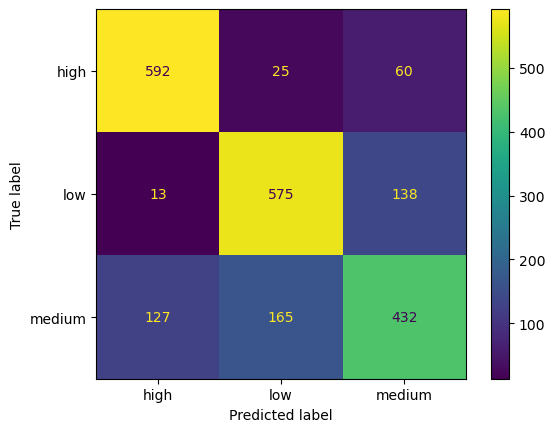

In [72]:
y_pred = rfc_scaled.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classfication Report

In [73]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       677
           1       0.75      0.79      0.77       726
           2       0.69      0.60      0.64       724

    accuracy                           0.75      2127
   macro avg       0.75      0.75      0.75      2127
weighted avg       0.75      0.75      0.75      2127



---

#### AdaBoostClassifier (estimator = DecisionTreeClassifier)

In [74]:
param_grid_abc_dt_scaled = { 
                     'n_estimators': [210,212,215,],
                     'learning_rate':[0.5,0.75,1]
                    }

dtc_scaled = DecisionTreeClassifier( 
                             criterion =grid_dtc_scaled.best_params_['criterion'],
                             splitter = grid_dtc_scaled.best_params_['splitter'],
                             max_features =  grid_dtc_scaled.best_params_['max_features'],
                             max_depth =  grid_dtc_scaled.best_params_['max_depth'], 
                             max_leaf_nodes = grid_dtc_scaled.best_params_['max_leaf_nodes'],
                             min_samples_split = grid_dtc_scaled.best_params_['min_samples_split']
    
                            )


abc_dt_scaled = AdaBoostClassifier(estimator = dtc_scaled)

grid_abc_dt_scaled= GridSearchCV(
                          abc_dt_scaled,
                          param_grid_abc_dt,
                          refit=True,verbose=3
                          )

grid_abc_dt_scaled.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.5, n_estimators=210;, score=0.764 total time=   6.1s
[CV 2/5] END learning_rate=0.5, n_estimators=210;, score=0.791 total time=   5.8s
[CV 3/5] END learning_rate=0.5, n_estimators=210;, score=0.756 total time=   5.4s
[CV 4/5] END learning_rate=0.5, n_estimators=210;, score=0.745 total time=   5.3s
[CV 5/5] END learning_rate=0.5, n_estimators=210;, score=0.754 total time=   5.4s
[CV 1/5] END learning_rate=0.5, n_estimators=212;, score=0.761 total time=   5.5s
[CV 2/5] END learning_rate=0.5, n_estimators=212;, score=0.777 total time=   5.4s
[CV 3/5] END learning_rate=0.5, n_estimators=212;, score=0.759 total time=   5.4s
[CV 4/5] END learning_rate=0.5, n_estimators=212;, score=0.745 total time=   5.5s
[CV 5/5] END learning_rate=0.5, n_estimators=212;, score=0.750 total time=   5.6s
[CV 1/5] END learning_rate=0.5, n_estimators=215;, score=0.761 total time=   5.6s
[CV 2/5] END learning_rate=0.5, n_esti

GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                                           max_depth=30,
                                                                           max_features='sqrt',
                                                                           max_leaf_nodes=1100,
                                                                           min_samples_split=4)),
             param_grid={'learning_rate': [0.5, 0.75, 1],
                         'n_estimators': [210, 212, 215]},
             verbose=3)

In [75]:
print(grid_abc_dt_scaled.best_params_)
print(grid_abc_dt_scaled.best_score_)

{'learning_rate': 0.75, 'n_estimators': 210}
0.7646147293691377


#### Model Fit

In [76]:
dtc_scaled = DecisionTreeClassifier( 
                             criterion =grid_dtc_scaled.best_params_['criterion'],
                             splitter = grid_dtc_scaled.best_params_['splitter'],
                             max_features =  grid_dtc_scaled.best_params_['max_features'],
                             max_depth =  grid_dtc_scaled.best_params_['max_depth'], 
                             max_leaf_nodes = grid_dtc_scaled.best_params_['max_leaf_nodes'],
                             min_samples_split = grid_dtc_scaled.best_params_['min_samples_split']
    
                            )

abc_dt_scaled = AdaBoostClassifier(
                        estimator = dtc_scaled,
                        n_estimators = grid_abc_dt_scaled.best_params_['n_estimators'],
                        learning_rate= grid_abc_dt_scaled.best_params_['learning_rate']
                        )

abc_dt_scaled.fit(X_train_scaled,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy',
                                                    max_depth=30,
                                                    max_features='sqrt',
                                                    max_leaf_nodes=1100,
                                                    min_samples_split=4),
                   learning_rate=0.75, n_estimators=210)

#### Confusion Matrix

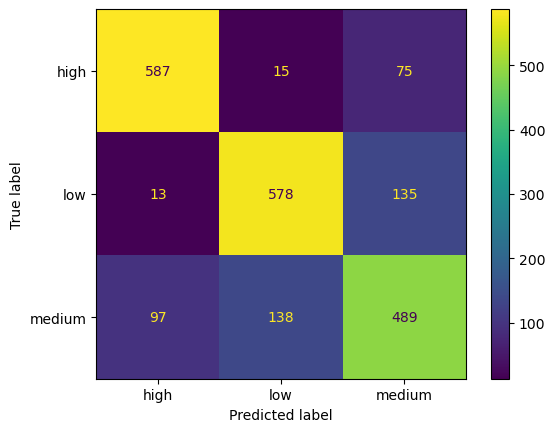

In [77]:
y_pred= abc_dt_scaled.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classification Report

In [78]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85       677
           1       0.79      0.80      0.79       726
           2       0.70      0.68      0.69       724

    accuracy                           0.78      2127
   macro avg       0.78      0.78      0.78      2127
weighted avg       0.78      0.78      0.78      2127



---

#### AdaBoostClassifier (estimator = RandomForestClassifier)

In [79]:
param_grid_abc_rfc_scaled = { 
                      'n_estimators': [210,212,215,],
                      'learning_rate':[0.5,0.75,1]
                     }

rfc_scaled = RandomForestClassifier( 
                             n_estimators = grid_rfc_scaled.best_params_['n_estimators'], 
                             max_features =  grid_rfc_scaled.best_params_['max_features'],
                             max_depth =  grid_rfc_scaled.best_params_['max_depth'], 
                             max_leaf_nodes = grid_rfc_scaled.best_params_['max_leaf_nodes'],
                             
                            )

abc_rfc_scaled = AdaBoostClassifier(estimator = rfc)

grid_abc_rfc_scaled = GridSearchCV(
                           abc_rfc_scaled,
                           param_grid_abc_rfc_scaled,
                           refit=True,verbose=3
                           )

grid_abc_rfc_scaled.fit(X_train_scaled,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.5, n_estimators=210;, score=0.746 total time=   2.6s
[CV 2/5] END learning_rate=0.5, n_estimators=210;, score=0.770 total time=   2.8s
[CV 3/5] END learning_rate=0.5, n_estimators=210;, score=0.752 total time=   2.9s
[CV 4/5] END learning_rate=0.5, n_estimators=210;, score=0.739 total time=   2.8s
[CV 5/5] END learning_rate=0.5, n_estimators=210;, score=0.746 total time=   2.8s
[CV 1/5] END learning_rate=0.5, n_estimators=212;, score=0.756 total time=   2.5s
[CV 2/5] END learning_rate=0.5, n_estimators=212;, score=0.764 total time=   2.6s
[CV 3/5] END learning_rate=0.5, n_estimators=212;, score=0.754 total time=   2.5s
[CV 4/5] END learning_rate=0.5, n_estimators=212;, score=0.747 total time=   2.5s
[CV 5/5] END learning_rate=0.5, n_estimators=212;, score=0.747 total time=   2.5s
[CV 1/5] END learning_rate=0.5, n_estimators=215;, score=0.746 total time=   2.5s
[CV 2/5] END learning_rate=0.5, n_esti

GridSearchCV(estimator=AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=30,
                                                                           max_leaf_nodes=1100,
                                                                           n_estimators=200)),
             param_grid={'learning_rate': [0.5, 0.75, 1],
                         'n_estimators': [210, 212, 215]},
             verbose=3)

In [80]:
print(grid_abc_rfc_scaled.best_params_)
print(grid_abc_rfc_scaled.best_score_)

{'learning_rate': 0.5, 'n_estimators': 212}
0.7536431880165847


### Mode Fit

In [81]:
rfc_scaled = RandomForestClassifier( 
                             n_estimators = grid_rfc_scaled.best_params_['n_estimators'], 
                             max_features =  grid_rfc_scaled.best_params_['max_features'],
                             max_depth =  grid_rfc_scaled.best_params_['max_depth'], 
                             max_leaf_nodes = grid_rfc_scaled.best_params_['max_leaf_nodes'],
                             #class_weight=class_weight_dict
    
                            )

abc_rfc_scaled = AdaBoostClassifier(
                             estimator = rfc,
                             n_estimators = grid_abc_rfc_scaled.best_params_['n_estimators'],
                             learning_rate= grid_abc_rfc_scaled.best_params_['learning_rate']
                            )

abc_rfc_scaled.fit(X_train_scaled,y_train)

AdaBoostClassifier(estimator=RandomForestClassifier(max_depth=30,
                                                    max_leaf_nodes=1100,
                                                    n_estimators=200),
                   learning_rate=0.5, n_estimators=212)

#### Confusion Matrix

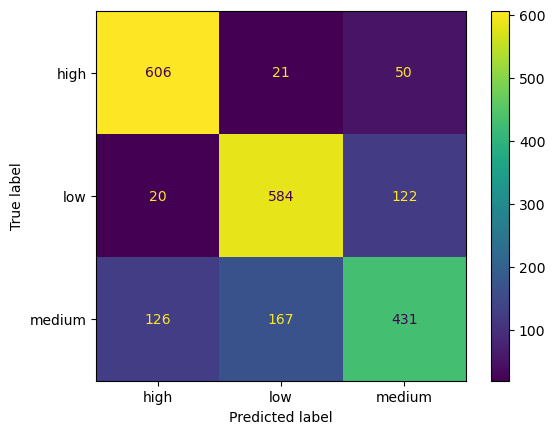

In [82]:
y_pred = abc_rfc_scaled.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classification Report

In [83]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85       677
           1       0.76      0.80      0.78       726
           2       0.71      0.60      0.65       724

    accuracy                           0.76      2127
   macro avg       0.76      0.76      0.76      2127
weighted avg       0.76      0.76      0.76      2127



---

---

### PCA Analysis

#### Viz

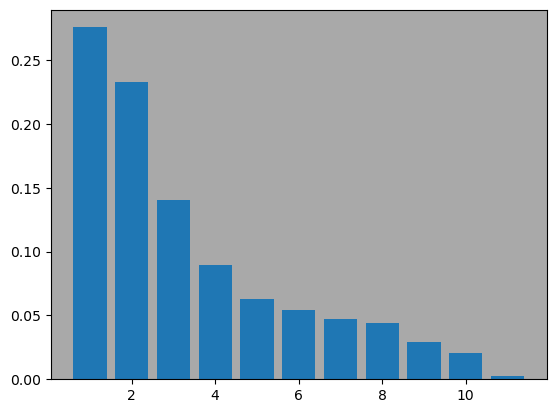

In [84]:
pca = PCA()
pca.fit(X_scaled)

pca.explained_variance_ratio_.shape[0]
n= [*range(1,pca.explained_variance_ratio_.shape[0]+1)]
plt.bar(n,pca.explained_variance_ratio_)
plt.show()

#### PCA Viz

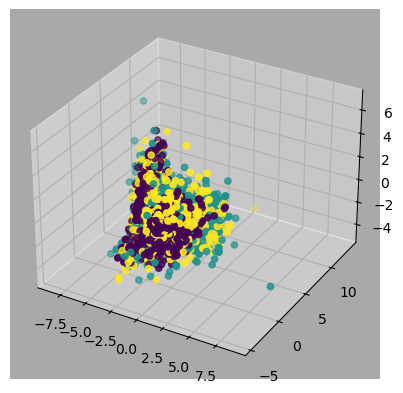

In [87]:

pca = PCA(n_components = 3)
X_pca = pca.fit_transform(X_scaled)

pca_1 = X_pca[:,0]
pca_2= X_pca[:,1]
pca_3 = X_pca[:,2]

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(pca_1, pca_2, pca_3, 'gray',c=y_resampled)
plt.show()

#### PCA Training & Testing Data

In [88]:
pca = PCA(n_components = 10)
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test =  pca.transform(X_test_scaled)

---

### Models

---

#### KNeighborsClassifier

In [89]:
train_scores_pca = []
test_scores_pca = []
for n in range(1,10):
    knc_pca = KNeighborsClassifier(n_neighbors = n)
    knc_pca.fit(
            X_pca_train,
            y_train
           )
    train_scores_pca.append(knc_pca.score(X_pca_train,y_train))
    test_scores_pca.append(knc_pca.score(X_pca_test,y_test))

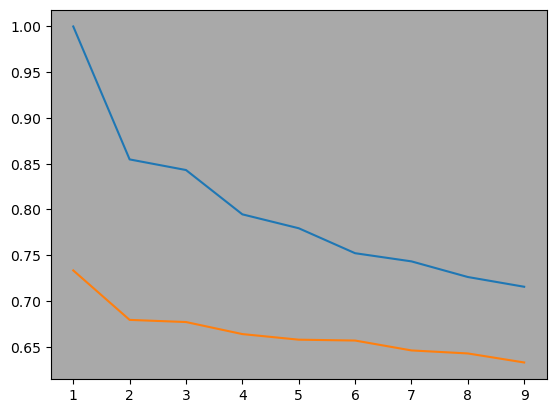

In [90]:
plt.plot([*range(1,10)],train_scores_pca)
plt.plot([*range(1,10)],test_scores_pca)
plt.show()

#### Model Fit

In [91]:
knc_pca = KNeighborsClassifier(n_neighbors = 1 )
knc_pca.fit(X_pca_train,y_train)

KNeighborsClassifier(n_neighbors=1)

#### Confusion Matrix

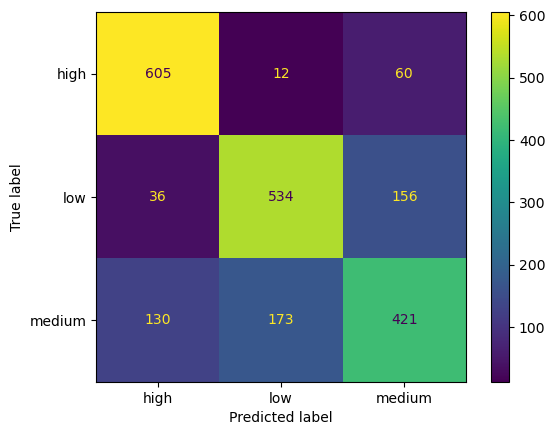

In [92]:
y_pred = knc_pca.predict(X_pca_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

In [93]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.89      0.84       677
           1       0.74      0.74      0.74       726
           2       0.66      0.58      0.62       724

    accuracy                           0.73      2127
   macro avg       0.73      0.74      0.73      2127
weighted avg       0.73      0.73      0.73      2127



---

#### SVC

In [94]:
param_grid_svc_pca = {
              'C': [5,10,15], 
              'gamma': [1,2,3,4],
              'kernel': ['rbf']
              }
grid_svc_pca= GridSearchCV(
                              SVC(),
                              param_grid_svc_pca,
                              refit=True,verbose=3
                             )

grid_svc_pca.fit(X_pca_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.736 total time=   1.7s
[CV 2/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.761 total time=   1.8s
[CV 3/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.757 total time=   1.7s
[CV 4/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.726 total time=   1.7s
[CV 5/5] END ..........C=5, gamma=1, kernel=rbf;, score=0.736 total time=   1.7s
[CV 1/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.724 total time=   1.7s
[CV 2/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.745 total time=   1.8s
[CV 3/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.741 total time=   1.7s
[CV 4/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.712 total time=   1.7s
[CV 5/5] END ..........C=5, gamma=2, kernel=rbf;, score=0.725 total time=   1.7s
[CV 1/5] END ..........C=5, gamma=3, kernel=rbf;, score=0.717 total time=   1.7s
[CV 2/5] END ..........C=5, gamma=3, kernel=rbf;

GridSearchCV(estimator=SVC(),
             param_grid={'C': [5, 10, 15], 'gamma': [1, 2, 3, 4],
                         'kernel': ['rbf']},
             verbose=3)

In [95]:
print(grid_svc_pca.best_params_)
print(grid_svc_pca.best_score_)

{'C': 5, 'gamma': 1, 'kernel': 'rbf'}
0.7433015516873158


#### Model Fit

In [96]:
C = grid_svc_pca.best_params_['C'] 
gamma = grid_svc_pca.best_params_['gamma']
kernel = grid_svc_pca.best_params_['kernel']
                              
svc_pca = SVC(C = C,
         gamma = gamma,
         kernel = kernel)

svc_pca.fit(X_pca_train,y_train)

SVC(C=5, gamma=1)

#### Confusion Matrix

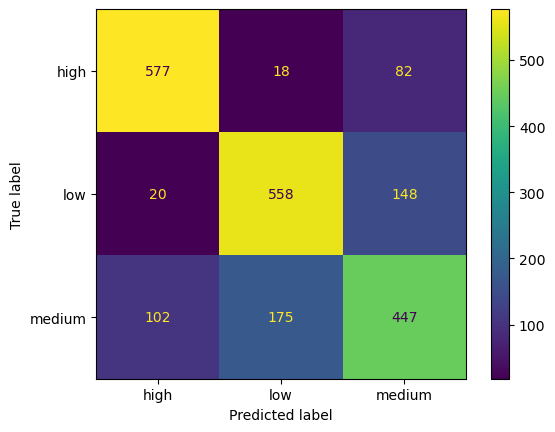

In [97]:
y_pred = svc_pca.predict(X_pca_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

In [98]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       677
           1       0.74      0.77      0.76       726
           2       0.66      0.62      0.64       724

    accuracy                           0.74      2127
   macro avg       0.74      0.75      0.74      2127
weighted avg       0.74      0.74      0.74      2127



---

#### Class Weights

In [99]:
classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced',
                                    classes=classes,
                                    y=y_train)
class_weight_dict = {clas: weight for clas, weight in zip(classes, weights)}


#### DecisionTreeClassifier

In [100]:
param_grid_dtc_pca = { 
                  'criterion': ['gini', 'entropy', 'log_loss'], 
                  'splitter': ['best','random'],
                  'max_features': ['sqrt', 'log2'],
                  'max_depth': [10,20, 30], 
                  'max_leaf_nodes': [900,1000,1100],
                  'min_samples_split': [4,6,8],
                    } 

grid_dtc_pca = GridSearchCV(
                        DecisionTreeClassifier(class_weight = class_weight_dict),
                        param_grid_dtc_pca,
                        refit=True,verbose=3,
                       )

grid_dtc_pca.fit(X_pca_train,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.615 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.610 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.618 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.589 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=best;, score=0.603 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.527 total time=   0.0s
[CV 2/5] END criterion=gini, max_d

[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.605 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.611 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.621 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.607 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.596 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, splitter=random;, score=0.514 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_sampl

[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.611 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.614 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, splitter=best;, score=0.583 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.463 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.545 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, splitter=random;, score=0.527 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_s

[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.592 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.605 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.591 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, splitter=random;, score=0.585 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.631 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.658 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_sample

[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.643 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.604 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.637 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.588 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.596 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.606 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_s

[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.623 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.647 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.636 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.610 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.632 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.572 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_sampl

[CV 3/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.621 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.599 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.619 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.603 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.621 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.607 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_

[CV 4/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.610 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.625 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.602 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.612 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.606 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.611 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min

[CV 1/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.594 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.621 total time=   0.0s
[CV 3/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.606 total time=   0.0s
[CV 4/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.595 total time=   0.0s
[CV 5/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.592 total time=   0.0s
[CV 1/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1100, min_samples_split=4, splitter=best;, score=0.610 total time=   0.0s
[CV 2/5] END criterion=gini, max_depth=30, max_features=log2, max_leaf_nodes=1100, m

[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.620 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.523 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.552 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.534 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.533 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.541 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_lea

[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.605 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.509 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.558 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.516 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.534 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.497 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, m

[CV 5/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.621 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.522 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.538 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.563 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.524 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.456 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=10, max_features=log2, m

[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.647 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.627 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.613 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.592 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.591 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.607 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_no

[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.623 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.624 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.624 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.602 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.618 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.591 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=sqrt, max_l

[CV 2/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.637 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.619 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.628 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.629 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.566 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.596 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, max_features=log2, max_lea

[CV 2/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.658 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.625 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.642 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.636 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.612 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.608 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_node

[CV 1/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.644 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.646 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.645 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.623 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.632 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.608 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=sqrt, max_leaf_

[CV 1/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.621 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.629 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.614 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.625 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.638 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.563 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=30, max_features=log2, max_leaf_

[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.617 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.602 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.586 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.522 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.564 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=random;, score=0.559 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_

[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.614 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.591 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=best;, score=0.602 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.551 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.507 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, splitter=random;, score=0.491 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=sqrt

[CV 3/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.619 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.574 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=best;, score=0.603 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.541 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.569 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, splitter=random;, score=0.532 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=10, max_features=log2

[CV 1/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.572 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.587 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.603 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.582 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.597 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, splitter=best;, score=0.605 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=sqrt, 

[CV 4/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.625 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.620 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.595 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.629 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.587 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.600 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=sq

[CV 3/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.629 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.630 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.631 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.590 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.603 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.589 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=20, max_features=log2

[CV 4/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.623 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=best;, score=0.632 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.594 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.601 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.598 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, splitter=random;, score=0.591 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=sqrt, ma

[CV 4/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.627 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=best;, score=0.616 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.597 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.617 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.609 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=6, splitter=random;, score=0.611 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=sq

[CV 4/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.654 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=best;, score=0.632 total time=   0.0s
[CV 1/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.583 total time=   0.0s
[CV 2/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.626 total time=   0.0s
[CV 3/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.615 total time=   0.0s
[CV 4/5] END criterion=log_loss, max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, splitter=random;, score=0.594 total time=   0.0s
[CV 5/5] END criterion=log_loss, max_depth=30, max_features=lo

GridSearchCV(estimator=DecisionTreeClassifier(class_weight={0: 0.9851783232978231,
                                                            1: 1.0080568720379146,
                                                            2: 1.0071022727272727}),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'max_leaf_nodes': [900, 1000, 1100],
                         'min_samples_split': [4, 6, 8],
                         'splitter': ['best', 'random']},
             verbose=3)

In [101]:
print(grid_dtc_pca.best_params_)
print(grid_dtc_pca.best_score_)

{'criterion': 'gini', 'max_depth': 30, 'max_features': 'log2', 'max_leaf_nodes': 1000, 'min_samples_split': 4, 'splitter': 'best'}
0.6519366019987087


#### Model Fit

In [102]:
dtc_pca = DecisionTreeClassifier( 
                             criterion =grid_dtc_pca.best_params_['criterion'],
                             splitter = grid_dtc_pca.best_params_['splitter'],
                             max_features =  grid_dtc_pca.best_params_['max_features'],
                             max_depth =  grid_dtc_pca.best_params_['max_depth'], 
                             max_leaf_nodes = grid_dtc_pca.best_params_['max_leaf_nodes'],
                             min_samples_split = grid_dtc_pca.best_params_['min_samples_split'],
                             class_weight = class_weight_dict
                            )

dtc_pca.fit(X_pca_train,y_train)

DecisionTreeClassifier(class_weight={0: 0.9851783232978231,
                                     1: 1.0080568720379146,
                                     2: 1.0071022727272727},
                       max_depth=30, max_features='log2', max_leaf_nodes=1000,
                       min_samples_split=4)

#### Confusion Matrix

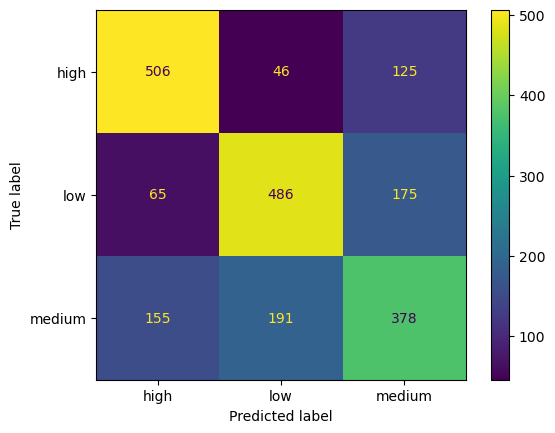

In [103]:
y_pred = dtc_pca.predict(X_pca_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classification Report

In [104]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       677
           1       0.67      0.67      0.67       726
           2       0.56      0.52      0.54       724

    accuracy                           0.64      2127
   macro avg       0.64      0.65      0.64      2127
weighted avg       0.64      0.64      0.64      2127



---

#### RandomForestClassifier

In [105]:
param_grid_rfc_pca = { 
                 'n_estimators': [200, 215,220], 
                 'max_features': ['sqrt', 'log2', None], 
                 'max_depth': [10,20, 30], 
                 'max_leaf_nodes': [900,1000,1100],
                 'min_samples_split': [4,6,8], 
                 } 

grid_rfc_pca = GridSearchCV(
                        RandomForestClassifier(class_weight = class_weight_dict),
                        param_grid_rfc_pca,
                        refit=True,verbose=3
                       )

grid_rfc_pca.fit(X_pca_train,y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.670 total time=   2.7s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.720 total time=   2.7s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.717 total time=   2.7s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.694 total time=   2.7s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.713 total time=   2.7s
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.680 total time=   2.9s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.

[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.675 total time=   2.6s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.711 total time=   2.7s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.714 total time=   2.7s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.699 total time=   2.7s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.713 total time=   2.6s
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.681 total time=   2.8s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.716 total time=   2.9s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.674 total time=   2.7s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.709 total time=   2.7s
[CV 3/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.715 total time=   2.7s
[CV 4/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.692 total time=   2.7s
[CV 5/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.709 total time=   2.7s
[CV 1/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.674 total time=   2.9s
[CV 2/5] END max_depth=10, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.717 total time=   2.9s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.682 total time=   2.7s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.720 total time=   2.7s
[CV 3/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.714 total time=   2.8s
[CV 4/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.705 total time=   2.7s
[CV 5/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.712 total time=   2.7s
[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.681 total time=   3.0s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.725 total time=   3.0s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.671 total time=   2.8s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.719 total time=   2.8s
[CV 3/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.718 total time=   2.7s
[CV 4/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.705 total time=   2.8s
[CV 5/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.713 total time=   2.7s
[CV 1/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.681 total time=   3.0s
[CV 2/5] END max_depth=10, max_features=log2, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.721 total time=   3.0s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.681 total time=   8.2s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.714 total time=   8.3s
[CV 3/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.715 total time=   8.2s
[CV 4/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.694 total time=   8.4s
[CV 5/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.709 total time=   8.3s
[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.680 total time=   8.8s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.713 total time=   8.9s
[CV 3/5] END max_depth=10, max_features=N

[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.675 total time=   8.0s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.720 total time=   8.1s
[CV 3/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.716 total time=   8.0s
[CV 4/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.698 total time=   8.6s
[CV 5/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.700 total time=   8.8s
[CV 1/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.688 total time=   8.6s
[CV 2/5] END max_depth=10, max_features=None, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.717 total time=   8.6s
[CV 3/5] END max_depth=10, max_fea

[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.722 total time=   3.3s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.753 total time=   3.3s
[CV 3/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.748 total time=   3.3s
[CV 4/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.736 total time=   3.3s
[CV 5/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.745 total time=   3.3s
[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.724 total time=   3.6s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.750 total time=   3.6s
[CV 3/5] END max_depth=20, max_features=s

[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.718 total time=   3.2s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.759 total time=   3.3s
[CV 3/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.738 total time=   3.2s
[CV 4/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.716 total time=   3.2s
[CV 5/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.738 total time=   3.2s
[CV 1/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.719 total time=   3.5s
[CV 2/5] END max_depth=20, max_features=sqrt, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.748 total time=   3.5s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.735 total time=   3.4s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.762 total time=   3.4s
[CV 3/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.741 total time=   3.3s
[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.733 total time=   3.4s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.737 total time=   3.4s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.726 total time=   3.6s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.756 total time=   3.6s
[CV 3/5] END max_depth=20, max_features=l

[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.727 total time=   3.3s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.748 total time=   3.3s
[CV 3/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.742 total time=   3.3s
[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.741 total time=   3.3s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.730 total time=   3.3s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.717 total time=   3.6s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.752 total time=   3.6s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.724 total time=   3.3s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.759 total time=   3.3s
[CV 3/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.736 total time=   3.3s
[CV 4/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.733 total time=   3.3s
[CV 5/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.741 total time=   3.2s
[CV 1/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.723 total time=   3.5s
[CV 2/5] END max_depth=20, max_features=log2, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.758 total time=   3.5s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.724 total time=  10.1s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.748 total time=  10.1s
[CV 3/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.752 total time=  10.0s
[CV 4/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.726 total time=  10.0s
[CV 5/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=200;, score=0.741 total time=  10.0s
[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.731 total time=  10.9s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1000, min_samples_split=4, n_estimators=215;, score=0.747 total time=  10.9s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.724 total time=  10.0s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.751 total time=  10.1s
[CV 3/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.739 total time=   9.9s
[CV 4/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.732 total time=   9.9s
[CV 5/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=200;, score=0.732 total time=   9.9s
[CV 1/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.731 total time=  10.8s
[CV 2/5] END max_depth=20, max_features=None, max_leaf_nodes=1100, min_samples_split=6, n_estimators=215;, score=0.748 total time=  10.8s
[CV 3/5] END max_depth=20, max_fea

[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.721 total time=   3.3s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.752 total time=   3.4s
[CV 3/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.734 total time=   3.2s
[CV 4/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.730 total time=   3.3s
[CV 5/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=200;, score=0.736 total time=   3.2s
[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.720 total time=   3.5s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=900, min_samples_split=8, n_estimators=215;, score=0.754 total time=   3.5s
[CV 3/5] END max_depth=30, max_features=s

[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.720 total time=   3.4s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.745 total time=   3.4s
[CV 3/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.739 total time=   3.3s
[CV 4/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.728 total time=   3.4s
[CV 5/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=200;, score=0.741 total time=   3.3s
[CV 1/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.733 total time=   3.6s
[CV 2/5] END max_depth=30, max_features=sqrt, max_leaf_nodes=1100, min_samples_split=4, n_estimators=215;, score=0.757 total time=   3.7s
[CV 3/5] END max_depth=30, max_fea

[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.731 total time=   3.3s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.751 total time=   3.3s
[CV 3/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.751 total time=   3.3s
[CV 4/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.736 total time=   3.3s
[CV 5/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=200;, score=0.737 total time=   3.3s
[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.731 total time=   3.6s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=900, min_samples_split=6, n_estimators=215;, score=0.755 total time=   3.6s
[CV 3/5] END max_depth=30, max_features=l

[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.723 total time=   3.3s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.752 total time=   3.2s
[CV 3/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.735 total time=   3.2s
[CV 4/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.724 total time=   3.3s
[CV 5/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=200;, score=0.734 total time=   3.3s
[CV 1/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.720 total time=   3.5s
[CV 2/5] END max_depth=30, max_features=log2, max_leaf_nodes=1000, min_samples_split=8, n_estimators=215;, score=0.763 total time=   3.5s
[CV 3/5] END max_depth=30, max_fea

[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.725 total time=  10.2s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.750 total time=  10.1s
[CV 3/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.743 total time=  10.0s
[CV 4/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.727 total time=  10.1s
[CV 5/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=200;, score=0.733 total time=  10.1s
[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.729 total time=  11.0s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=900, min_samples_split=4, n_estimators=215;, score=0.752 total time=  10.9s
[CV 3/5] END max_depth=30, max_features=N

[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.722 total time=  10.2s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.752 total time=  10.1s
[CV 3/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.742 total time=  10.0s
[CV 4/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.723 total time=  10.0s
[CV 5/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=200;, score=0.732 total time=  10.1s
[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.728 total time=  10.9s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1000, min_samples_split=6, n_estimators=215;, score=0.748 total time=  10.9s
[CV 3/5] END max_depth=30, max_fea

[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.719 total time=  10.0s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.748 total time=  10.0s
[CV 3/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.745 total time=   9.8s
[CV 4/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.723 total time=   9.9s
[CV 5/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=200;, score=0.733 total time=   9.9s
[CV 1/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.720 total time=  10.7s
[CV 2/5] END max_depth=30, max_features=None, max_leaf_nodes=1100, min_samples_split=8, n_estimators=215;, score=0.755 total time=  10.7s
[CV 3/5] END max_depth=30, max_fea

GridSearchCV(estimator=RandomForestClassifier(class_weight={0: 0.9851783232978231,
                                                            1: 1.0080568720379146,
                                                            2: 1.0071022727272727}),
             param_grid={'max_depth': [10, 20, 30],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [900, 1000, 1100],
                         'min_samples_split': [4, 6, 8],
                         'n_estimators': [200, 215, 220]},
             verbose=3)

In [106]:
print(grid_rfc_pca.best_params_)
print(grid_rfc_pca.best_score_)

{'max_depth': 30, 'max_features': 'log2', 'max_leaf_nodes': 1100, 'min_samples_split': 4, 'n_estimators': 200}
0.7451834113554741


#### Model Fit

In [107]:
rfc_pca = RandomForestClassifier( 
                             n_estimators = grid_rfc_pca.best_params_['n_estimators'], 
                             max_features =  grid_rfc_pca.best_params_['max_features'],
                             max_depth =  grid_rfc_pca.best_params_['max_depth'], 
                             max_leaf_nodes = grid_rfc_pca.best_params_['max_leaf_nodes'],
                             class_weight = class_weight_dict
                            )

rfc_pca.fit(X_pca_train,y_train)

RandomForestClassifier(class_weight={0: 0.9851783232978231,
                                     1: 1.0080568720379146,
                                     2: 1.0071022727272727},
                       max_depth=30, max_features='log2', max_leaf_nodes=1100,
                       n_estimators=200)

#### Confusion Matrix

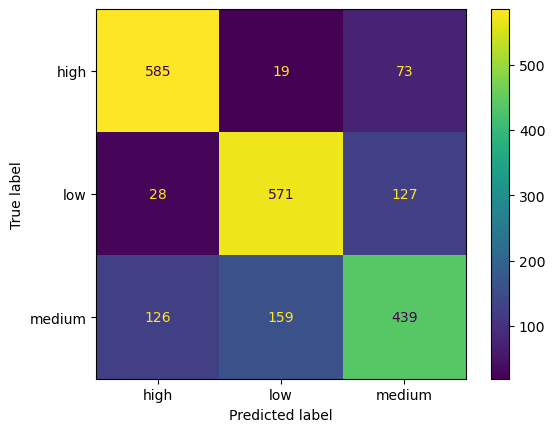

In [108]:
y_pred = rfc_pca.predict(X_pca_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classification Report

In [109]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       677
           1       0.76      0.79      0.77       726
           2       0.69      0.61      0.64       724

    accuracy                           0.75      2127
   macro avg       0.75      0.75      0.75      2127
weighted avg       0.75      0.75      0.75      2127



---

#### AdaBoostClassifier(estimator = DecisionTreeClassifier )

In [110]:
param_grid_abc_dtc_pca = { 
                     'n_estimators': [210,212,215,],
                     'learning_rate':[0.5,0.75,1]
                    }

dtc_pca = DecisionTreeClassifier( 
                             criterion =grid_dtc_pca.best_params_['criterion'],
                             splitter = grid_dtc_pca.best_params_['splitter'],
                             max_features =  grid_dtc_pca.best_params_['max_features'],
                             max_depth =  grid_dtc_pca.best_params_['max_depth'], 
                             max_leaf_nodes = grid_dtc_pca.best_params_['max_leaf_nodes'],
                             min_samples_split = grid_dtc_pca.best_params_['min_samples_split'],
                             class_weight = class_weight_dict
                            )


abc_dtc_pca = AdaBoostClassifier(estimator = dtc_pca)

grid_abc_dtc_pca= GridSearchCV(
                          abc_dtc_pca,
                          param_grid_abc_dtc_pca,
                          refit=True,verbose=3
                          )

grid_abc_dtc_pca.fit(X_pca_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.5, n_estimators=210;, score=0.742 total time=   6.4s
[CV 2/5] END learning_rate=0.5, n_estimators=210;, score=0.768 total time=   6.2s
[CV 3/5] END learning_rate=0.5, n_estimators=210;, score=0.756 total time=   6.4s
[CV 4/5] END learning_rate=0.5, n_estimators=210;, score=0.744 total time=   6.3s
[CV 5/5] END learning_rate=0.5, n_estimators=210;, score=0.745 total time=   6.4s
[CV 1/5] END learning_rate=0.5, n_estimators=212;, score=0.746 total time=   6.3s
[CV 2/5] END learning_rate=0.5, n_estimators=212;, score=0.773 total time=   6.3s
[CV 3/5] END learning_rate=0.5, n_estimators=212;, score=0.757 total time=   6.4s
[CV 4/5] END learning_rate=0.5, n_estimators=212;, score=0.747 total time=   6.4s
[CV 5/5] END learning_rate=0.5, n_estimators=212;, score=0.751 total time=   6.4s
[CV 1/5] END learning_rate=0.5, n_estimators=215;, score=0.742 total time=   6.4s
[CV 2/5] END learning_rate=0.5, n_esti

GridSearchCV(estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 0.9851783232978231,
                                                                                         1: 1.0080568720379146,
                                                                                         2: 1.0071022727272727},
                                                                           max_depth=30,
                                                                           max_features='log2',
                                                                           max_leaf_nodes=1000,
                                                                           min_samples_split=4)),
             param_grid={'learning_rate': [0.5, 0.75, 1],
                         'n_estimators': [210, 212, 215]},
             verbose=3)

In [111]:
print(grid_abc_dtc_pca.best_params_)
print(grid_abc_dtc_pca.best_score_)

{'learning_rate': 1, 'n_estimators': 212}
0.7564646273716563


#### Model Fit

In [112]:
dtc_pca = DecisionTreeClassifier( 
                             criterion =grid_dtc_pca.best_params_['criterion'],
                             splitter = grid_dtc_pca.best_params_['splitter'],
                             max_features =  grid_dtc_pca.best_params_['max_features'],
                             max_depth =  grid_dtc_pca.best_params_['max_depth'], 
                             max_leaf_nodes = grid_dtc_pca.best_params_['max_leaf_nodes'],
                             min_samples_split = grid_dtc_pca.best_params_['min_samples_split'],
                             class_weight = class_weight_dict
                            )
abc_dtc_pca = AdaBoostClassifier(
                        estimator = dtc_pca,
                        n_estimators = grid_abc_dtc_pca.best_params_['n_estimators'],
                        learning_rate= grid_abc_dtc_pca.best_params_['learning_rate']
                        )

abc_dtc_pca.fit(X_pca_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(class_weight={0: 0.9851783232978231,
                                                                  1: 1.0080568720379146,
                                                                  2: 1.0071022727272727},
                                                    max_depth=30,
                                                    max_features='log2',
                                                    max_leaf_nodes=1000,
                                                    min_samples_split=4),
                   learning_rate=1, n_estimators=212)

#### Confusion Matrix

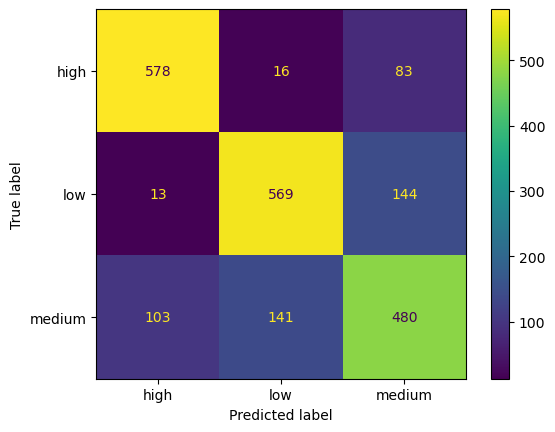

In [113]:
y_pred =abc_dtc_pca.predict(X_pca_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classfication Report

In [114]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       677
           1       0.78      0.78      0.78       726
           2       0.68      0.66      0.67       724

    accuracy                           0.76      2127
   macro avg       0.77      0.77      0.77      2127
weighted avg       0.76      0.76      0.76      2127



---

#### AdaBoostClassifier(estimator = RandonForestClassifier )

In [115]:
param_grid_abc_rfc_pca = { 
                      'n_estimators': [210,212,215,],
                      'learning_rate':[0.5,0.75,1]
                     }

rfc_pca = RandomForestClassifier( 
                             n_estimators = grid_rfc_pca.best_params_['n_estimators'], 
                             max_features =  grid_rfc_pca.best_params_['max_features'],
                             max_depth =  grid_rfc_pca.best_params_['max_depth'], 
                             max_leaf_nodes = grid_rfc_pca.best_params_['max_leaf_nodes'],
                             class_weight = class_weight_dict
                            )

abc_rfc_pca = AdaBoostClassifier(estimator = rfc_pca)

grid_abc_rfc_pca = GridSearchCV(
                           abc_rfc_pca,
                           param_grid_abc_rfc_pca,
                           refit=True,verbose=3
                           )

grid_abc_rfc_pca.fit(X_pca_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END learning_rate=0.5, n_estimators=210;, score=0.738 total time=   3.6s
[CV 2/5] END learning_rate=0.5, n_estimators=210;, score=0.754 total time=   3.6s
[CV 3/5] END learning_rate=0.5, n_estimators=210;, score=0.748 total time=   3.6s
[CV 4/5] END learning_rate=0.5, n_estimators=210;, score=0.737 total time=   3.6s
[CV 5/5] END learning_rate=0.5, n_estimators=210;, score=0.746 total time=   3.6s
[CV 1/5] END learning_rate=0.5, n_estimators=212;, score=0.738 total time=   3.6s
[CV 2/5] END learning_rate=0.5, n_estimators=212;, score=0.757 total time=   3.6s
[CV 3/5] END learning_rate=0.5, n_estimators=212;, score=0.748 total time=   3.6s
[CV 4/5] END learning_rate=0.5, n_estimators=212;, score=0.734 total time=   3.7s
[CV 5/5] END learning_rate=0.5, n_estimators=212;, score=0.745 total time=   3.6s
[CV 1/5] END learning_rate=0.5, n_estimators=215;, score=0.737 total time=   3.6s
[CV 2/5] END learning_rate=0.5, n_esti

GridSearchCV(estimator=AdaBoostClassifier(estimator=RandomForestClassifier(class_weight={0: 0.9851783232978231,
                                                                                         1: 1.0080568720379146,
                                                                                         2: 1.0071022727272727},
                                                                           max_depth=30,
                                                                           max_features='log2',
                                                                           max_leaf_nodes=1100,
                                                                           n_estimators=200)),
             param_grid={'learning_rate': [0.5, 0.75, 1],
                         'n_estimators': [210, 212, 215]},
             verbose=3)

In [116]:
print(grid_abc_rfc_pca.best_params_)
print(grid_abc_rfc_pca.best_score_)

{'learning_rate': 0.75, 'n_estimators': 210}
0.7480025186381679


#### Model Fit

In [117]:
rfc_pca = RandomForestClassifier( 
                             n_estimators = grid_rfc_pca.best_params_['n_estimators'], 
                             max_features =  grid_rfc_pca.best_params_['max_features'],
                             max_depth =  grid_rfc_pca.best_params_['max_depth'], 
                             max_leaf_nodes = grid_rfc_pca.best_params_['max_leaf_nodes'],
                             class_weight = class_weight_dict
    
                            )

abc_rfc_pca = AdaBoostClassifier(
                             estimator = rfc_pca,
                             n_estimators = grid_abc_rfc_pca.best_params_['n_estimators'],
                             learning_rate= grid_abc_rfc_pca.best_params_['learning_rate']
                            )

abc_rfc_pca.fit(X_pca_train,y_train)

AdaBoostClassifier(estimator=RandomForestClassifier(class_weight={0: 0.9851783232978231,
                                                                  1: 1.0080568720379146,
                                                                  2: 1.0071022727272727},
                                                    max_depth=30,
                                                    max_features='log2',
                                                    max_leaf_nodes=1100,
                                                    n_estimators=200),
                   learning_rate=0.75, n_estimators=210)

#### Confusion Matrix

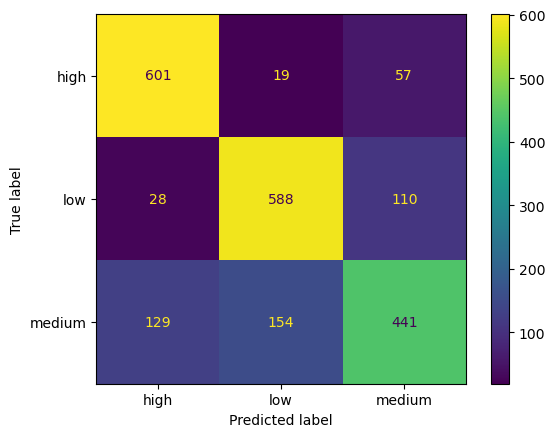

In [118]:
y_pred = abc_rfc_pca.predict(X_pca_test)

cm = confusion_matrix(y_test, y_pred)

display = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=le.classes_)
display.plot()
plt.show()

#### Classification Report

In [119]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       677
           1       0.77      0.81      0.79       726
           2       0.73      0.61      0.66       724

    accuracy                           0.77      2127
   macro avg       0.76      0.77      0.76      2127
weighted avg       0.76      0.77      0.76      2127

